In [1]:
# Add graphviz to path
import os

os.environ["PATH"] = os.environ["PATH"] + ":/opt/homebrew/bin"

# Imports
from datetime import date
from itertools import product
from pprint import pprint

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from vaxflux.covariates import (
    CovariateCategories,
    GaussianRandomWalkCovariate,
    PooledCovariate,
)
from vaxflux.curves import LogisticIncidenceCurve
from vaxflux.data import sample_dataset
from vaxflux.dates import SeasonRange, daily_date_ranges
from vaxflux.uptake import SeasonalUptakeModel

In [2]:
logistic_curve = LogisticIncidenceCurve()
logistic_curve

In [3]:
logistic_curve.parameters

('m', 'r', 's')

In [4]:
range_days = 6
season_ranges = [
    SeasonRange(
        season="2022/23", start_date=date(2022, 9, 5), end_date=date(2023, 1, 29)
    ),
    SeasonRange(
        season="2023/24", start_date=date(2023, 9, 4), end_date=date(2024, 1, 28)
    ),
    SeasonRange(
        season="2024/25", start_date=date(2024, 9, 2), end_date=date(2025, 1, 26)
    ),
]
date_ranges = daily_date_ranges(season_ranges, range_days=range_days)

In [5]:
sex_cov = CovariateCategories(covariate="sex", categories=("female", "male"))
age_cov = CovariateCategories(
    covariate="age", categories=("adult", "senior", "elderly")
)

In [6]:
params = []

params_grid = {
    "2022/23": {
        "m": -0.5,
        "r": -3.2,
        "s": 40.0,
        "male": {
            "m": -0.05,
        },
        "senior": {
            "m": 1.0,
        },
        "elderly": {
            "m": 1.8,
        },
    },
    "2023/24": {
        "m": -0.55,
        "r": -3.1,
        "s": 42.5,
        "male": {
            "m": -0.06,
        },
        "senior": {
            "m": 1.05,
        },
        "elderly": {
            "m": 1.75,
        },
    },
    "2024/25": {
        "m": -0.51,
        "r": -3.3,
        "s": 41.0,
        "male": {
            "m": -0.04,
        },
        "senior": {
            "m": 1.1,
        },
        "elderly": {
            "m": 1.85,
        },
    },
}

for curve_param in logistic_curve.parameters:
    for season_range in season_ranges:
        for sex_category in sex_cov.categories:
            for age_category in age_cov.categories:
                season_params = params_grid[season_range.season]
                param_value = (
                    season_params[curve_param]
                    + season_params.get(sex_category, {}).get(curve_param, 0)
                    + season_params.get(age_category, {}).get(curve_param, 0)
                )
                params.append(
                    (
                        curve_param,
                        season_range.season,
                        sex_category,
                        age_category,
                        param_value,
                    )
                )

pprint(params)

[('m', '2022/23', 'female', 'adult', -0.5),
 ('m', '2022/23', 'female', 'senior', 0.5),
 ('m', '2022/23', 'female', 'elderly', 1.3),
 ('m', '2022/23', 'male', 'adult', -0.55),
 ('m', '2022/23', 'male', 'senior', 0.44999999999999996),
 ('m', '2022/23', 'male', 'elderly', 1.25),
 ('m', '2023/24', 'female', 'adult', -0.55),
 ('m', '2023/24', 'female', 'senior', 0.5),
 ('m', '2023/24', 'female', 'elderly', 1.2),
 ('m', '2023/24', 'male', 'adult', -0.6100000000000001),
 ('m', '2023/24', 'male', 'senior', 0.43999999999999995),
 ('m', '2023/24', 'male', 'elderly', 1.14),
 ('m', '2024/25', 'female', 'adult', -0.51),
 ('m', '2024/25', 'female', 'senior', 0.5900000000000001),
 ('m', '2024/25', 'female', 'elderly', 1.34),
 ('m', '2024/25', 'male', 'adult', -0.55),
 ('m', '2024/25', 'male', 'senior', 0.55),
 ('m', '2024/25', 'male', 'elderly', 1.3),
 ('r', '2022/23', 'female', 'adult', -3.2),
 ('r', '2022/23', 'female', 'senior', -3.2),
 ('r', '2022/23', 'female', 'elderly', -3.2),
 ('r', '2022/23

In [7]:
observations = sample_dataset(
    logistic_curve, season_ranges, date_ranges, [sex_cov, age_cov], params, 0.002
)
observations

,season,season_start_date,season_end_date,start_date,end_date,report_date,sex,age,type,value
0,2022/23,2022-09-05,2023-01-29,2022-09-05,2022-09-11,2022-09-11,female,adult,incidence,0.014487
1,2022/23,2022-09-05,2023-01-29,2022-09-05,2022-09-11,2022-09-11,female,senior,incidence,0.021868
2,2022/23,2022-09-05,2023-01-29,2022-09-05,2022-09-11,2022-09-11,female,elderly,incidence,0.034454
3,2022/23,2022-09-05,2023-01-29,2022-09-05,2022-09-11,2022-09-11,male,adult,incidence,0.009229
4,2022/23,2022-09-05,2023-01-29,2022-09-05,2022-09-11,2022-09-11,male,senior,incidence,0.021154
...,...,...,...,...,...,...,...,...,...,...
373,2024/25,2024-09-02,2025-01-26,2025-01-20,2025-01-26,2025-01-26,female,senior,incidence,0.000354
374,2024/25,2024-09-02,2025-01-26,2025-01-20,2025-01-26,2025-01-26,female,elderly,incidence,0.000040
375,2024/25,2024-09-02,2025-01-26,2025-01-20,2025-01-26,2025-01-26,male,adult,incidence,0.000009
376,2024/25,2024-09-02,2025-01-26,2025-01-20,2025-01-26,2025-01-26,male,senior,incidence,0.013781


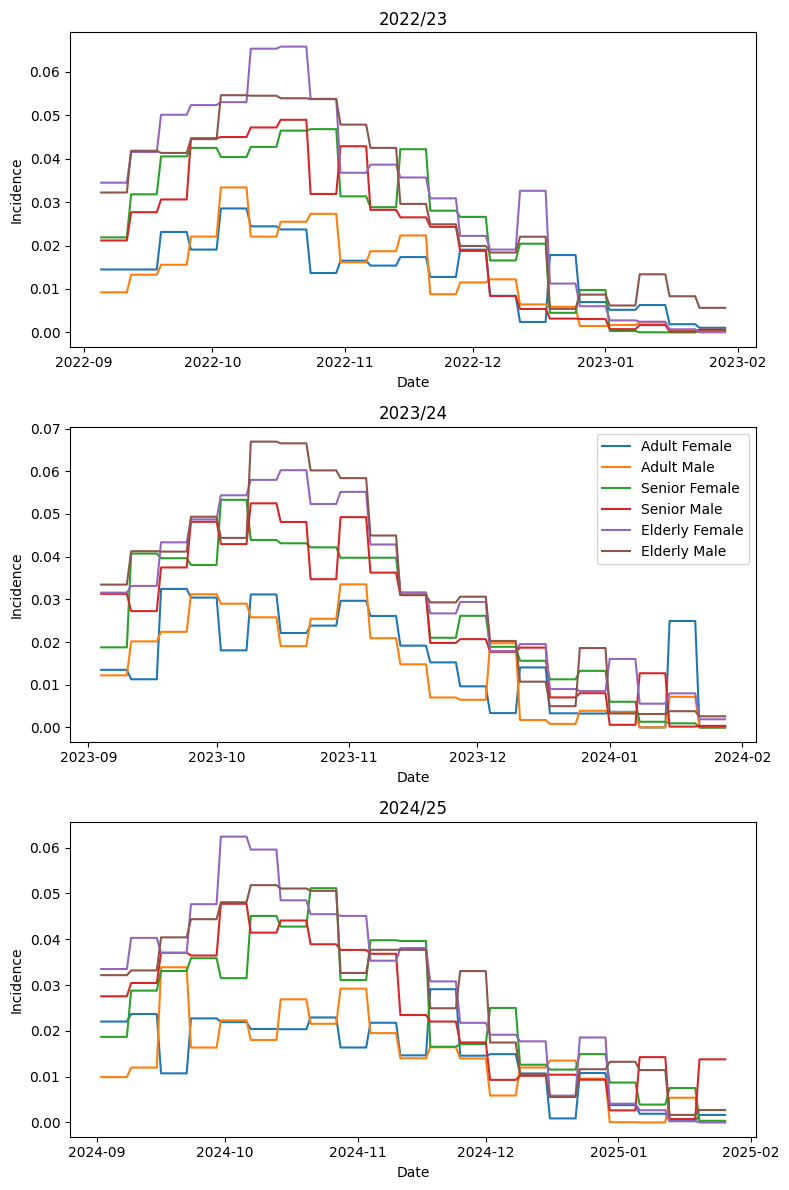

In [8]:
fig, axes = plt.subplots(
    nrows=len(season_ranges),
    ncols=1,
    figsize=(8, 12),
)

for i, season_range in enumerate(season_ranges):
    ax = axes[i]
    ax.set_title(season_range.season)
    ax.set_xlabel("Date")
    ax.set_ylabel("Incidence")
    for age_category in age_cov.categories:
        for sex_category in sex_cov.categories:
            observations_subset = observations[
                (observations["season"] == season_range.season)
                & (observations["age"] == age_category)
                & (observations["sex"] == sex_category)
            ]
            x = [
                el
                for pair in zip(
                    observations_subset["start_date"].tolist(),
                    observations_subset["end_date"].tolist(),
                )
                for el in pair
            ]
            y = [
                el
                for pair in zip(
                    observations_subset["value"].tolist(),
                    observations_subset["value"].tolist(),
                )
                for el in pair
            ]
            ax.plot(x, y, label=f"{age_category.title()} {sex_category.title()}")
    if i == (len(season_ranges) // 2):
        ax.legend()

fig.tight_layout()
plt.show()

In [9]:
observations_prevalence = observations.copy()
observations_prevalence = observations_prevalence.sort_values(
    [
        "start_date",
        "end_date",
        "season",
        "season_start_date",
        "season_end_date",
        "sex",
        "age",
    ]
)
observations_prevalence["prevalence"] = (
    observations_prevalence.groupby(["season", "sex", "age"])["value"]
    .cumsum()
    .reset_index()["value"]
)
observations_prevalence

,season,season_start_date,season_end_date,start_date,end_date,report_date,sex,age,type,value,prevalence
0,2022/23,2022-09-05,2023-01-29,2022-09-05,2022-09-11,2022-09-11,female,adult,incidence,0.014487,0.014487
2,2022/23,2022-09-05,2023-01-29,2022-09-05,2022-09-11,2022-09-11,female,elderly,incidence,0.034454,0.021868
1,2022/23,2022-09-05,2023-01-29,2022-09-05,2022-09-11,2022-09-11,female,senior,incidence,0.021868,0.034454
3,2022/23,2022-09-05,2023-01-29,2022-09-05,2022-09-11,2022-09-11,male,adult,incidence,0.009229,0.009229
5,2022/23,2022-09-05,2023-01-29,2022-09-05,2022-09-11,2022-09-11,male,elderly,incidence,0.032191,0.021154
...,...,...,...,...,...,...,...,...,...,...,...
374,2024/25,2024-09-02,2025-01-26,2025-01-20,2025-01-26,2025-01-26,female,elderly,incidence,0.000040,0.515605
373,2024/25,2024-09-02,2025-01-26,2025-01-20,2025-01-26,2025-01-26,female,senior,incidence,0.000354,0.613816
375,2024/25,2024-09-02,2025-01-26,2025-01-20,2025-01-26,2025-01-26,male,adult,incidence,0.000009,0.300352
377,2024/25,2024-09-02,2025-01-26,2025-01-20,2025-01-26,2025-01-26,male,elderly,incidence,0.002711,0.511787


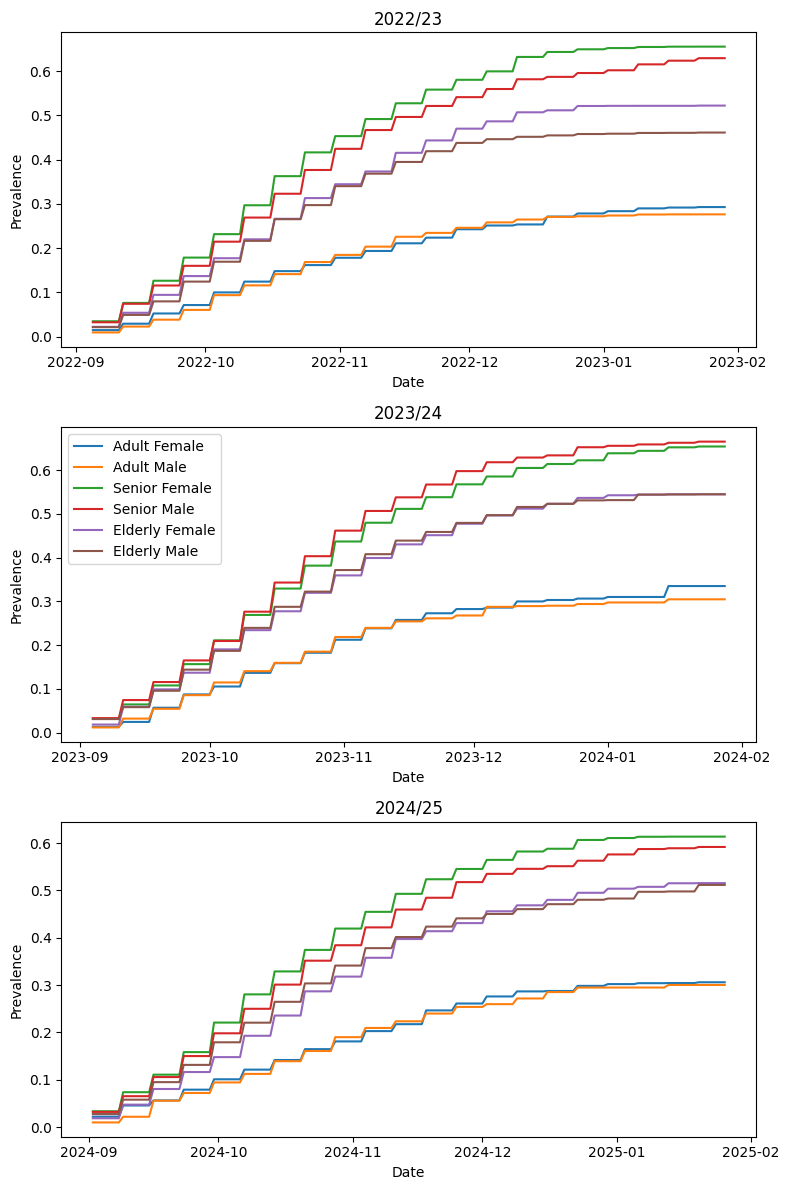

In [10]:
fig, axes = plt.subplots(
    nrows=len(season_ranges),
    ncols=1,
    figsize=(8, 12),
)

for i, season_range in enumerate(season_ranges):
    ax = axes[i]
    ax.set_title(season_range.season)
    ax.set_xlabel("Date")
    ax.set_ylabel("Prevalence")
    for age_category in age_cov.categories:
        for sex_category in sex_cov.categories:
            observations_subset = observations_prevalence[
                (observations_prevalence["season"] == season_range.season)
                & (observations_prevalence["age"] == age_category)
                & (observations_prevalence["sex"] == sex_category)
            ]
            x = [
                el
                for pair in zip(
                    observations_subset["start_date"].tolist(),
                    observations_subset["end_date"].tolist(),
                )
                for el in pair
            ]
            y = [
                el
                for pair in zip(
                    observations_subset["prevalence"].tolist(),
                    observations_subset["prevalence"].tolist(),
                )
                for el in pair
            ]
            ax.plot(x, y, label=f"{age_category.title()} {sex_category.title()}")
    if i == (len(season_ranges) // 2):
        ax.legend()

fig.tight_layout()
plt.show()

In [11]:
model = SeasonalUptakeModel(
    logistic_curve,
    [
        PooledCovariate(
            parameter="m",
            covariate=None,
            distribution="Normal",
            distribution_kwargs={"mu": -0.5, "sigma": 0.25},
        ),
        PooledCovariate(
            parameter="r",
            covariate=None,
            distribution="Normal",
            distribution_kwargs={"mu": -3.0, "sigma": 0.5},
        ),
        PooledCovariate(
            parameter="s",
            covariate=None,
            distribution="Normal",
            distribution_kwargs={"mu": 40.0, "sigma": 5.0},
        ),
        GaussianRandomWalkCovariate(
            parameter="m",
            covariate="age",
            init_mu=[1.0, 2.0],
            mu=2 * [0.0],
            sigma=2 * [0.25],
            eta=2.0,
        ),
        GaussianRandomWalkCovariate(
            parameter="m",
            covariate="sex",
            init_mu=-0.5,
            mu=0.0,
            sigma=0.1,
        ),
    ],
    observations=observations,
    covariate_categories=[sex_cov, age_cov],
    season_ranges=season_ranges,
    date_ranges=date_ranges,
    epsilon=0.01,
    # Custom keyword arguments
    constrain_prevalence=False,
    observation_sigma=1e-5,
    pooled_epsilon=True,
)
model

In [12]:
model.build(debug=False)

In [13]:
model.sample(
    tune=4000,
    draws=1000,
    chains=4,
)

Running window adaptation


There were 96 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


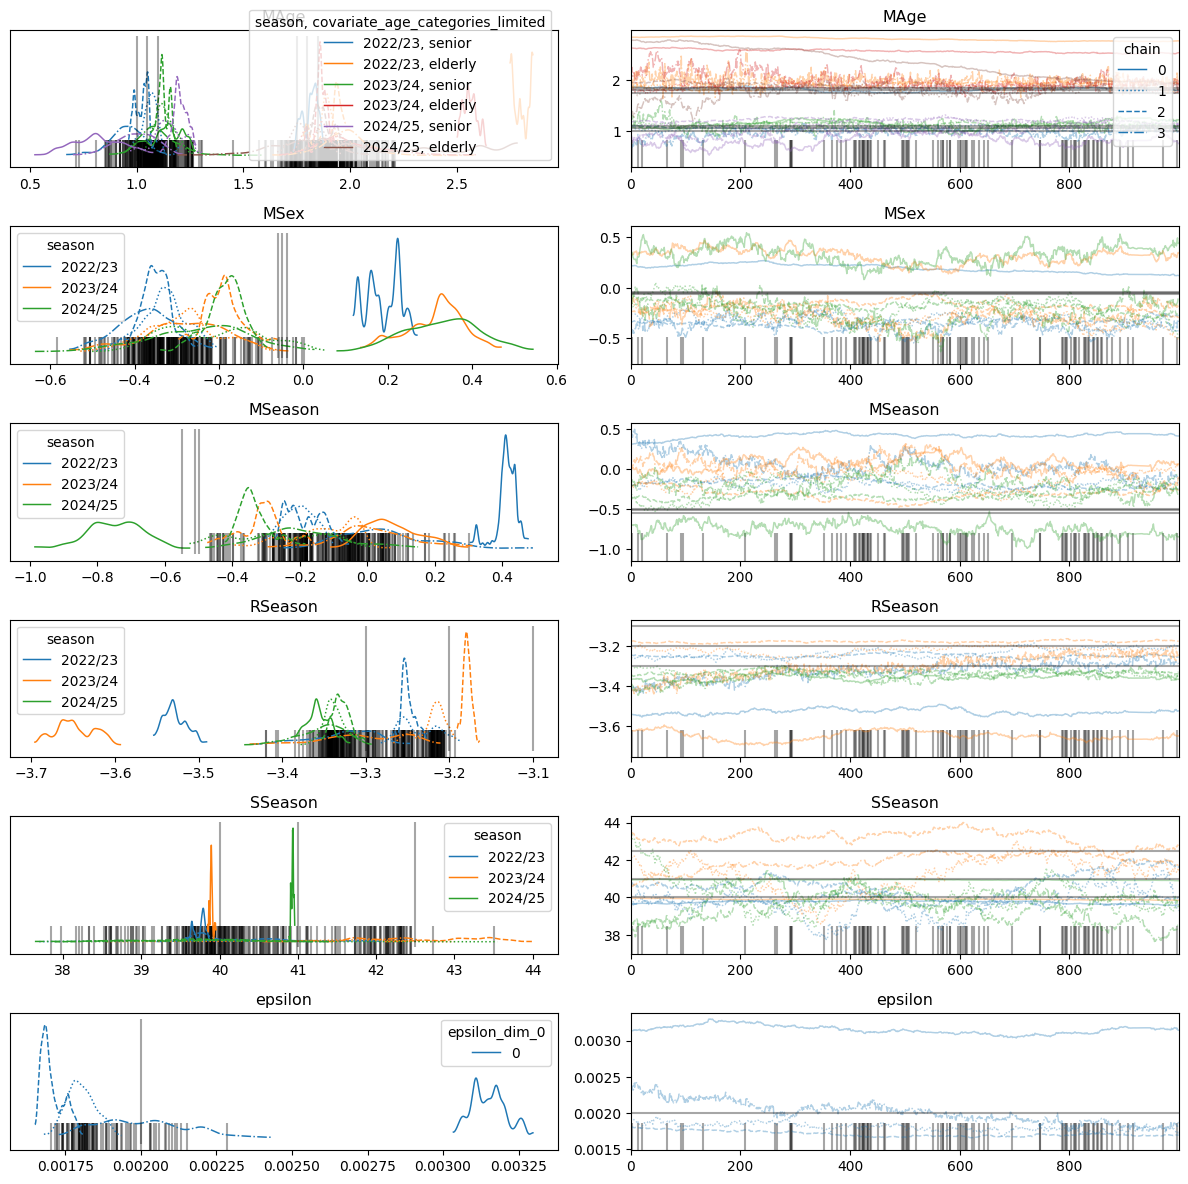

In [14]:
az.plot_trace(
    model._trace,
    var_names=["MAge", "MSex", "MSeason", "RSeason", "SSeason", "epsilon"],
    lines=[
        ("MAge", {}, [1.0, 1.8, 1.05, 1.75, 1.1, 1.85]),
        ("MSex", {}, [-0.05, -0.06, -0.04]),
        ("MSeason", {}, [-0.5, -0.55, -0.51]),
        ("RSeason", {}, [-3.2, -3.1, -3.3]),
        ("SSeason", {}, [40.0, 42.5, 41.0]),
        ("epsilon", {}, [0.002]),
    ],
    legend=True,
    compact=True,
)
plt.tight_layout()

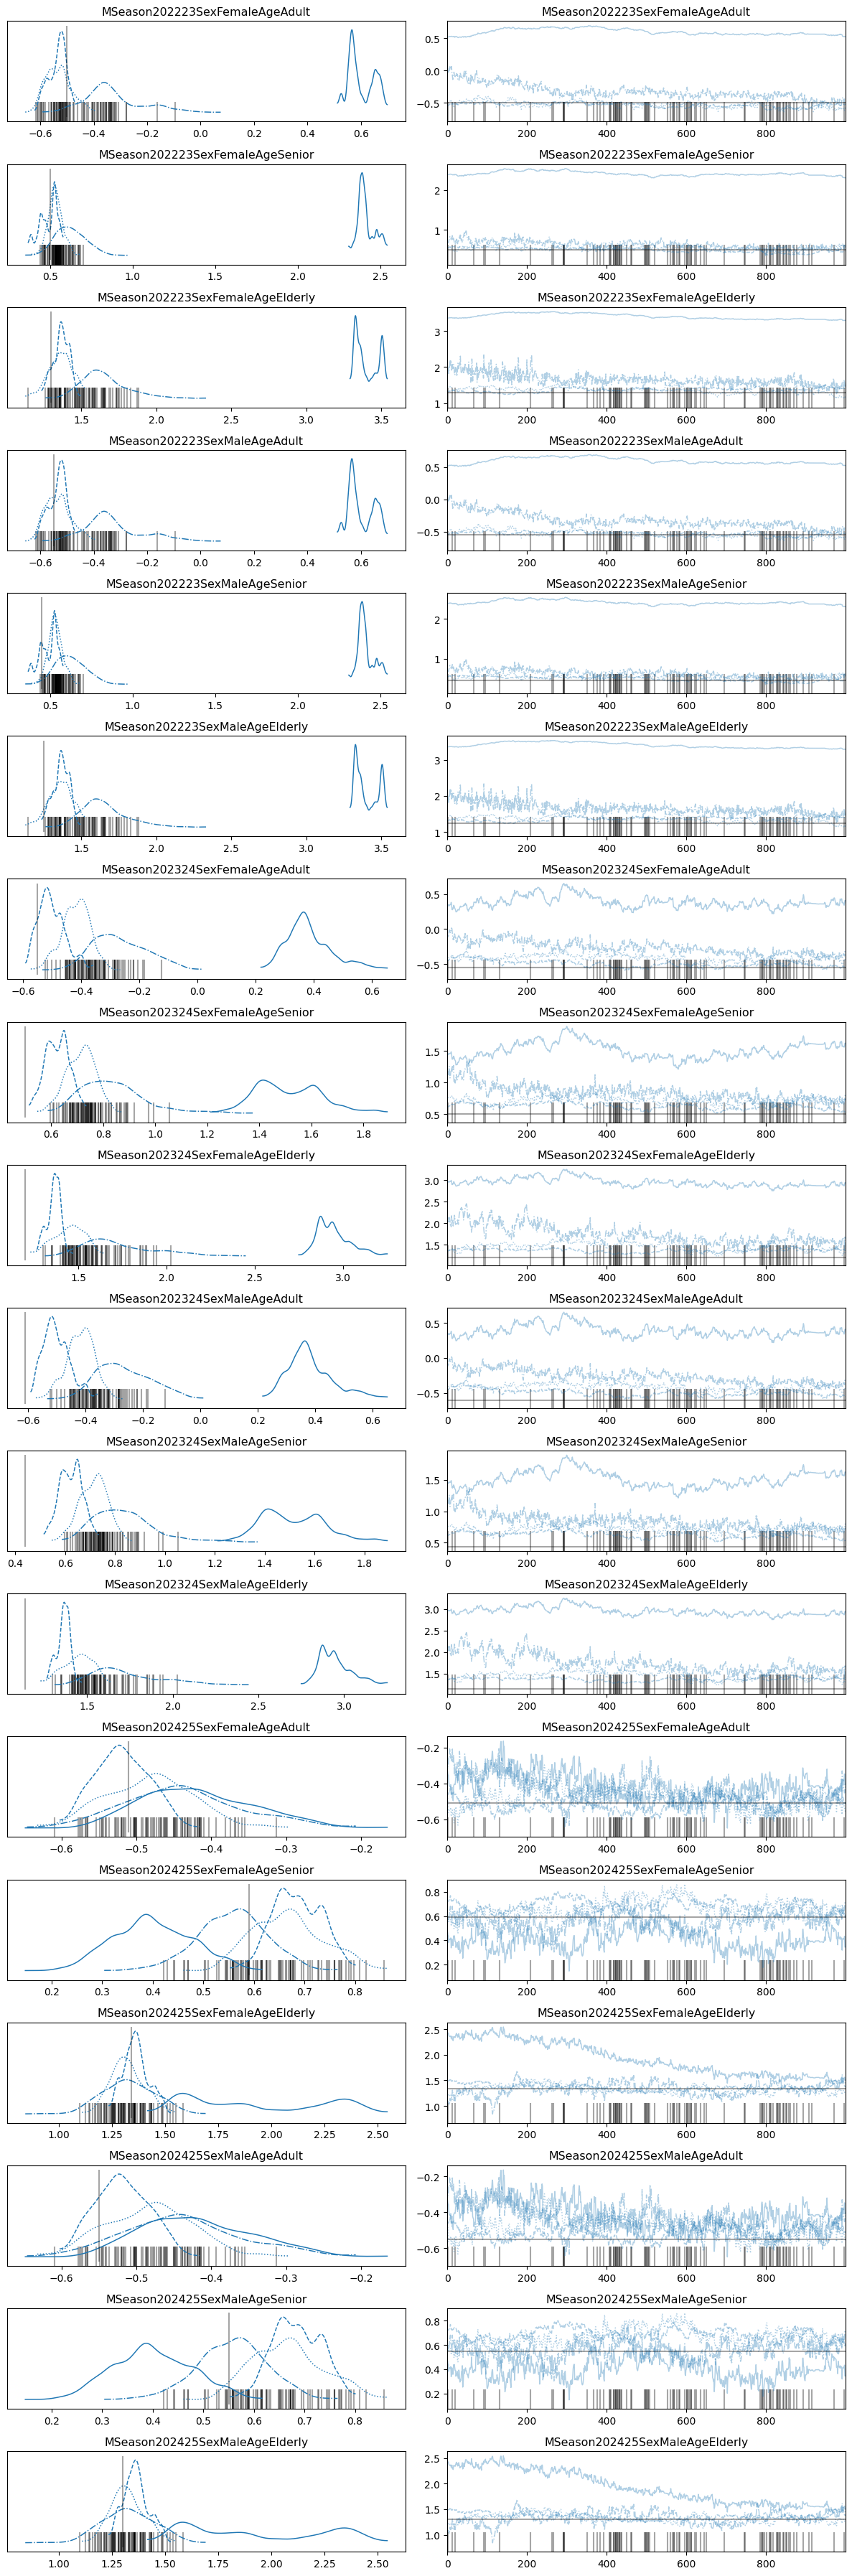

In [15]:
var_names_and_lines = {
    (
        f"{p[0].title()}Season{p[1].replace('/', '').title()}"
        f"Sex{p[2].title()}Age{p[3].title()}"
    ): p[4]
    for p in params
    if p[0] == "m"
}

az.plot_trace(
    model._trace,
    var_names=list(var_names_and_lines.keys()),
    lines=[(k, {}, v) for k, v in var_names_and_lines.items()],
)
plt.tight_layout()

In [16]:
posterior_df = model.dataframe()
posterior_df.head(10)

,draw,chain,season,date,sex,age,type,value
0,0,0,2022/23,2022-09-05,female,adult,incidence,0.001580
1,0,0,2022/23,2022-09-06,female,adult,incidence,0.002389
2,0,0,2022/23,2022-09-07,female,adult,incidence,0.002848
3,0,0,2022/23,2022-09-08,female,adult,incidence,0.001696
4,0,0,2022/23,2022-09-09,female,adult,incidence,0.002450
5,0,0,2022/23,2022-09-10,female,adult,incidence,0.002250
6,0,0,2022/23,2022-09-11,female,adult,incidence,0.001273
7,0,0,2022/23,2022-09-12,female,adult,incidence,0.001757
8,0,0,2022/23,2022-09-13,female,adult,incidence,0.003250
9,0,0,2022/23,2022-09-14,female,adult,incidence,0.001460


In [17]:
posterior_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10584000 entries, 0 to 587999
Data columns (total 8 columns):
 #   Column  Dtype         
---  ------  -----         
 0   draw    int64         
 1   chain   int64         
 2   season  string        
 3   date    datetime64[ns]
 4   sex     string        
 5   age     string        
 6   type    string        
 7   value   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), string(4)
memory usage: 726.7 MB


In [18]:
posterior_df = (
    posterior_df.drop(columns=["type"])
    .rename(columns={"value": "incidence"})
    .sort_values(["draw", "chain", "season", "sex", "age", "date"])
)
posterior_df["prevalence"] = posterior_df.groupby(
    ["draw", "chain", "season", "sex", "age"]
)["incidence"].cumsum()
posterior_df

,draw,chain,season,date,sex,age,incidence,prevalence
0,0,0,2022/23,2022-09-05,female,adult,1.579691e-03,0.001580
1,0,0,2022/23,2022-09-06,female,adult,2.388914e-03,0.003969
2,0,0,2022/23,2022-09-07,female,adult,2.847751e-03,0.006816
3,0,0,2022/23,2022-09-08,female,adult,1.695540e-03,0.008512
4,0,0,2022/23,2022-09-09,female,adult,2.450407e-03,0.010962
...,...,...,...,...,...,...,...,...
587995,999,3,2024/25,2025-01-22,male,senior,4.539793e-05,0.504877
587996,999,3,2024/25,2025-01-23,male,senior,5.863929e-07,0.504877
587997,999,3,2024/25,2025-01-24,male,senior,5.584178e-07,0.504878
587998,999,3,2024/25,2025-01-25,male,senior,1.121766e-19,0.504878


In [19]:
range_days_to_freq = {
    6: "W",
}
if range_days > 0:
    if (freq := range_days_to_freq.get(range_days)) is None:
        raise RuntimeError(
            f"Range days {range_days} not supported, "
            f"please add to `range_days_to_freq` dictionary."
        )
    incidence_posterior_df = (
        posterior_df.groupby(
            ["chain", "draw", "season", pd.Grouper(key="date", freq=freq), "sex", "age"]
        )["incidence"]
        .sum()
        .reset_index()
    )
incidence_posterior_df = (
    incidence_posterior_df if range_days > 0 else posterior_df
).rename(columns={"date": "end_date"})
incidence_posterior_df["start_date"] = incidence_posterior_df[
    "end_date"
] - pd.Timedelta(days=range_days)
incidence_posterior_df = (
    incidence_posterior_df.groupby(["season", "start_date", "end_date", "sex", "age"])[
        "incidence"
    ]
    .agg(
        [
            lambda x: np.quantile(x, 0.005),
            lambda x: np.quantile(x, 0.5),
            lambda x: np.quantile(x, 0.995),
        ]
    )
    .reset_index()
)
incidence_posterior_df = incidence_posterior_df.rename(
    columns={
        incidence_posterior_df.columns[-3]: "lower",
        incidence_posterior_df.columns[-2]: "median",
        incidence_posterior_df.columns[-1]: "upper",
    }
)
incidence_posterior_df

,season,start_date,end_date,sex,age,lower,median,upper
0,2022/23,2022-09-05,2022-09-11,female,adult,1.446135e-02,1.448675e-02,0.014512
1,2022/23,2022-09-05,2022-09-11,female,elderly,3.442774e-02,3.445415e-02,0.034480
2,2022/23,2022-09-05,2022-09-11,female,senior,2.184222e-02,2.186746e-02,0.021894
3,2022/23,2022-09-05,2022-09-11,male,adult,9.204484e-03,9.228926e-03,0.009253
4,2022/23,2022-09-05,2022-09-11,male,elderly,3.216502e-02,3.219122e-02,0.032217
...,...,...,...,...,...,...,...,...
373,2024/25,2025-01-20,2025-01-26,female,elderly,9.419882e-07,3.858433e-05,0.000066
374,2024/25,2025-01-20,2025-01-26,female,senior,4.997076e-07,3.497758e-04,0.000377
375,2024/25,2025-01-20,2025-01-26,male,adult,1.106166e-11,4.371375e-07,0.000034
376,2024/25,2025-01-20,2025-01-26,male,elderly,1.119285e-06,2.706136e-03,0.002734


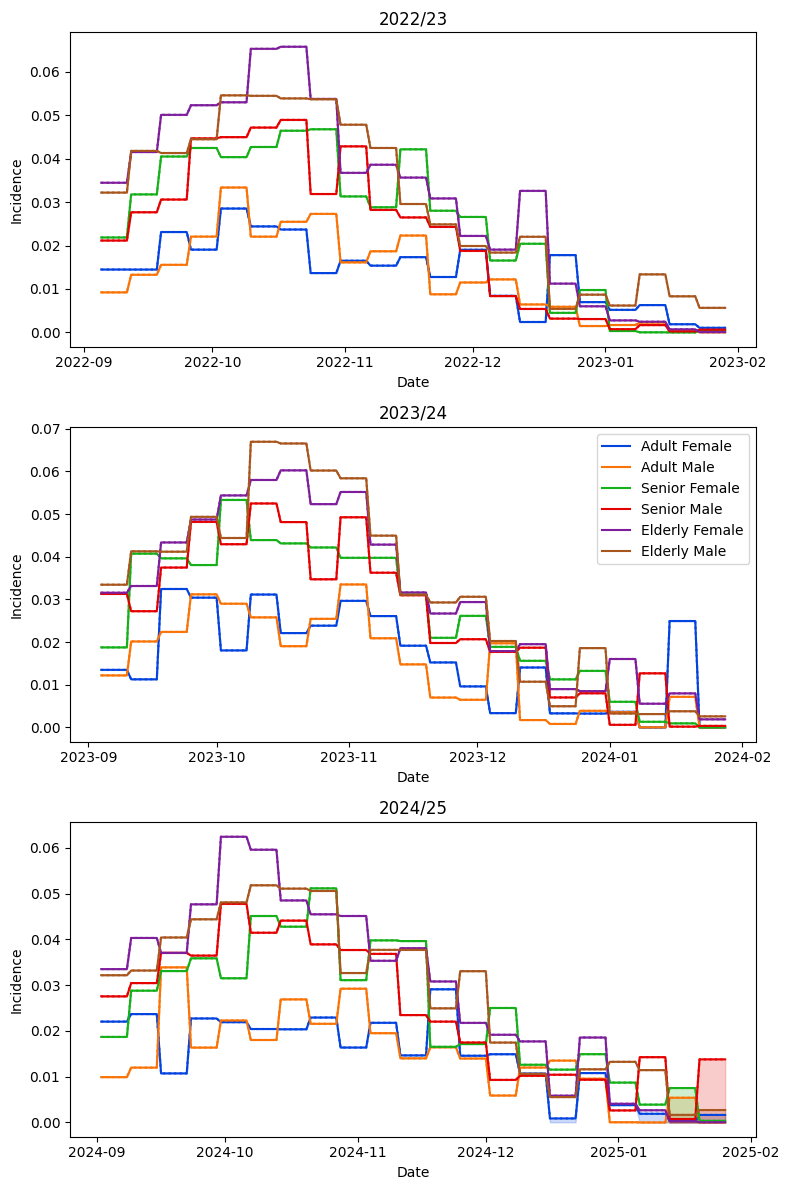

In [20]:
fig, axes = plt.subplots(
    nrows=len(season_ranges),
    ncols=1,
    figsize=(8, 12),
)

colors = (
    "xkcd:blue",
    "xkcd:orange",
    "xkcd:green",
    "xkcd:red",
    "xkcd:purple",
    "xkcd:sienna",
)
colors_map = {
    hash((age_category, sex_category)): color
    for color, (age_category, sex_category) in zip(
        colors, product(age_cov.categories, sex_cov.categories)
    )
}

for i, season_range in enumerate(season_ranges):
    ax = axes[i]
    ax.set_title(season_range.season)
    ax.set_xlabel("Date")
    ax.set_ylabel("Incidence")
    for age_category in age_cov.categories:
        for sex_category in sex_cov.categories:
            color = colors_map[hash((age_category, sex_category))]
            observations_subset = observations[
                (observations["season"] == season_range.season)
                & (observations["age"] == age_category)
                & (observations["sex"] == sex_category)
            ]
            x = [
                el
                for pair in zip(
                    observations_subset["start_date"].tolist(),
                    observations_subset["end_date"].tolist(),
                )
                for el in pair
            ]
            y = [
                el
                for pair in zip(
                    observations_subset["value"].tolist(),
                    observations_subset["value"].tolist(),
                )
                for el in pair
            ]
            ax.plot(
                x,
                y,
                label=f"{age_category.title()} {sex_category.title()}",
                color=color,
                linestyle="-",
            )

            summary_posterior_subset = incidence_posterior_df[
                (incidence_posterior_df["season"] == season_range.season)
                & (incidence_posterior_df["age"] == age_category)
                & (incidence_posterior_df["sex"] == sex_category)
            ]
            x = [
                el
                for pair in zip(
                    summary_posterior_subset["start_date"].tolist(),
                    summary_posterior_subset["end_date"].tolist(),
                )
                for el in pair
            ]
            y = [
                el
                for pair in zip(
                    summary_posterior_subset["median"].tolist(),
                    summary_posterior_subset["median"].tolist(),
                )
                for el in pair
            ]
            ax.plot(x, y, color=color, linestyle=":")

            y1 = [
                el
                for pair in zip(
                    summary_posterior_subset["lower"].tolist(),
                    summary_posterior_subset["lower"].tolist(),
                )
                for el in pair
            ]
            y2 = [
                el
                for pair in zip(
                    summary_posterior_subset["upper"].tolist(),
                    summary_posterior_subset["upper"].tolist(),
                )
                for el in pair
            ]
            ax.fill_between(x, y1, y2, color=color, alpha=0.2)
    if i == (len(season_ranges) // 2):
        ax.legend()

fig.tight_layout()
plt.show()

In [21]:
prevalence_posterior_df = (
    posterior_df.groupby(["season", "date", "sex", "age"])["prevalence"]
    .agg(
        [
            lambda x: np.quantile(x, 0.005),
            lambda x: np.quantile(x, 0.5),
            lambda x: np.quantile(x, 0.995),
        ]
    )
    .reset_index()
)
prevalence_posterior_df = prevalence_posterior_df.rename(
    columns={
        prevalence_posterior_df.columns[-3]: "lower",
        prevalence_posterior_df.columns[-2]: "median",
        prevalence_posterior_df.columns[-1]: "upper",
    }
)
prevalence_posterior_df

,season,date,sex,age,lower,median,upper
0,2022/23,2022-09-05,female,adult,0.000582,0.001723,0.005140
1,2022/23,2022-09-05,female,elderly,0.001770,0.004124,0.009493
2,2022/23,2022-09-05,female,senior,0.001010,0.003568,0.006524
3,2022/23,2022-09-05,male,adult,0.000076,0.001035,0.002922
4,2022/23,2022-09-05,male,elderly,0.000879,0.004203,0.007381
...,...,...,...,...,...,...,...
2641,2024/25,2025-01-26,female,elderly,0.613428,0.613798,0.613929
2642,2024/25,2025-01-26,female,senior,0.507663,0.515586,0.515713
2643,2024/25,2025-01-26,male,adult,0.294824,0.300337,0.300466
2644,2024/25,2025-01-26,male,elderly,0.587534,0.591950,0.592081


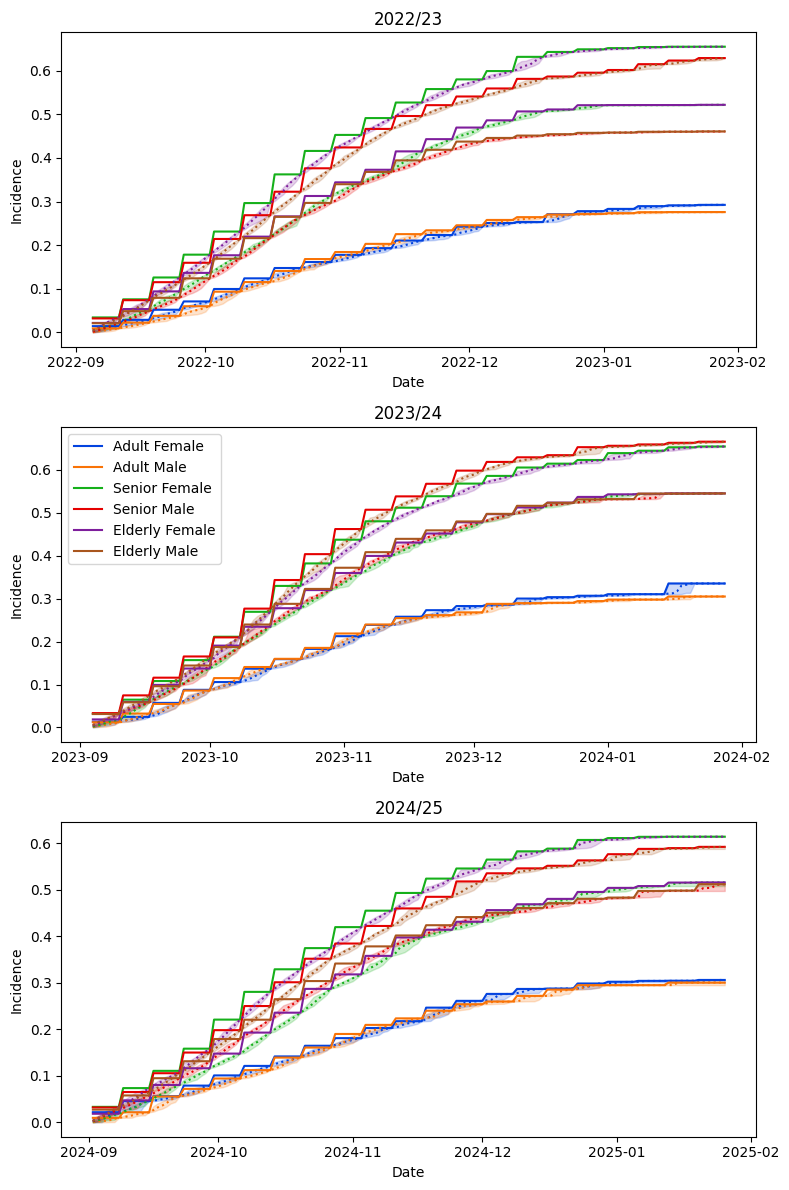

In [22]:
fig, axes = plt.subplots(
    nrows=len(season_ranges),
    ncols=1,
    figsize=(8, 12),
)

colors = (
    "xkcd:blue",
    "xkcd:orange",
    "xkcd:green",
    "xkcd:red",
    "xkcd:purple",
    "xkcd:sienna",
)
colors_map = {
    hash((age_category, sex_category)): color
    for color, (age_category, sex_category) in zip(
        colors, product(age_cov.categories, sex_cov.categories)
    )
}

for i, season_range in enumerate(season_ranges):
    ax = axes[i]
    ax.set_title(season_range.season)
    ax.set_xlabel("Date")
    ax.set_ylabel("Incidence")
    for age_category in age_cov.categories:
        for sex_category in sex_cov.categories:
            color = colors_map[hash((age_category, sex_category))]
            observations_subset = observations_prevalence[
                (observations_prevalence["season"] == season_range.season)
                & (observations_prevalence["age"] == age_category)
                & (observations_prevalence["sex"] == sex_category)
            ]
            x = [
                el
                for pair in zip(
                    observations_subset["start_date"].tolist(),
                    observations_subset["end_date"].tolist(),
                )
                for el in pair
            ]
            y = [
                el
                for pair in zip(
                    observations_subset["prevalence"].tolist(),
                    observations_subset["prevalence"].tolist(),
                )
                for el in pair
            ]
            ax.plot(
                x,
                y,
                label=f"{age_category.title()} {sex_category.title()}",
                color=color,
                linestyle="-",
            )

            summary_posterior_subset = prevalence_posterior_df[
                (prevalence_posterior_df["season"] == season_range.season)
                & (prevalence_posterior_df["age"] == age_category)
                & (prevalence_posterior_df["sex"] == sex_category)
            ]

            x = summary_posterior_subset["date"].tolist()
            y = summary_posterior_subset["median"].tolist()
            ax.plot(x, y, color=color, linestyle=":")

            y1 = summary_posterior_subset["lower"].tolist()
            y2 = summary_posterior_subset["upper"].tolist()
            ax.fill_between(x, y1, y2, color=color, alpha=0.2)
    if i == (len(season_ranges) // 2):
        ax.legend()

fig.tight_layout()
plt.show()